In [2]:
import os
import re
from matplotlib import pyplot as plt
from lexicalrichness import LexicalRichness
import pandas as pd
import numpy as np

In [3]:
def load_book(filename: str) -> str:
    '''
    Takes a filename of a txt file from project gutenberg and strips the text from the file.
    '''
    lines = [l.rstrip() for l in open(filename, 'r', encoding='utf8')]
    
    exp = re.compile(r'^\*\*\* (START|END).*PROJECT GUTENBERG.*\*\*\*$')
    start, end = [lines.index(l) for l in lines if exp.match(l)]
    lines = lines[start+1:end]
    text =  ' '.join(lines)
    return text

### Collect The Book Paths
Below, the directories containing the English and German books were scanned. The titles of the books within the directories are listed below. A dictionary containing all the book paths is also created. 

In [4]:
books_dir = 'books'
engl_books = os.listdir(books_dir + '/English')
germ_books = os.listdir(books_dir + '/German')

book_paths = {'English':[], 'German':[]}
print('The following books have been collected: ')
print('\t{:>3s} {:<30s}'.format('#', 'title'))
for i, book in enumerate(set(engl_books) | set(germ_books)):
    title = book.rstrip('.txt')
    if len(title) > 22: title = title[:23] + '...'
    in_engl, in_germ = book in engl_books, book in germ_books
    print('\t{:>3d} {:<30s} {:<10b} {:<10b}'.format(i+1, title, in_engl, in_germ))
    if in_engl:
        book_paths['English'].append((title, books_dir + '/English/' + book))
    if in_germ:
        book_paths['German'].append((title, books_dir + '/German/' + book))

The following books have been collected: 
	  # title                         
	  1 Oliver Twist Charles Di...     1          1         
	  2 Romeo and Juliet Shakes...     1          1         
	  3 Peter Pan James Barrie         1          1         
	  4 A Christmas Carol Charl...     1          1         
	  5 Alices Adventures in Wo...     1          1         
	  6 Macbeth Shakespeare            1          1         
	  7 Treasure Island Robert ...     1          1         


### Create a Dataframe With Book Info
Next we create a dataframe that contains a few lexicographical properties of the books. Each book is loaded individually and the data is saved in the dataframe, this could provide scalibility of the quantity of books for a future project. 

In [5]:
col_names = ['title', 'language', 'words', 'terms', 'moving avg', 'maas diversity']
df = pd.DataFrame(columns=col_names)
for k in book_paths.keys():
    for title, path in book_paths[k]:
        text = load_book(path)
        lex = LexicalRichness(text)
        df.loc[len(df.index)] = [title, k, lex.words, lex.terms, lex.mattr(), lex.Maas]

### Generation of Plots
Below is the generation of a few plots. Bar charts were produced to visualize some of the lexicographical properties of each book with that of the translated version next to it. 

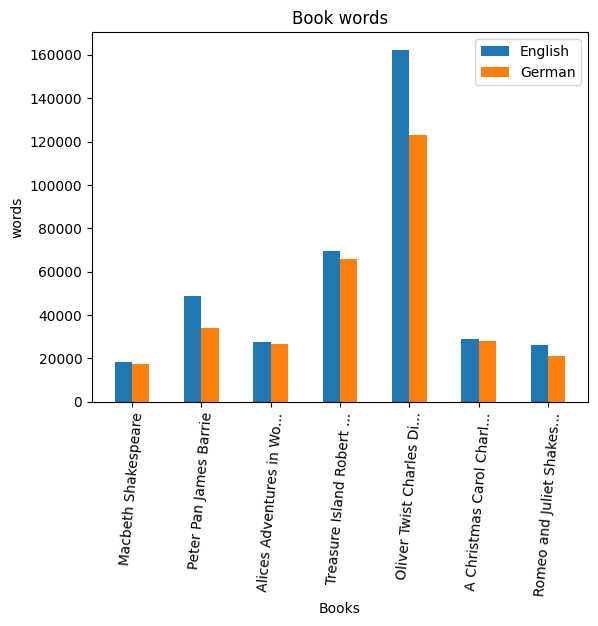

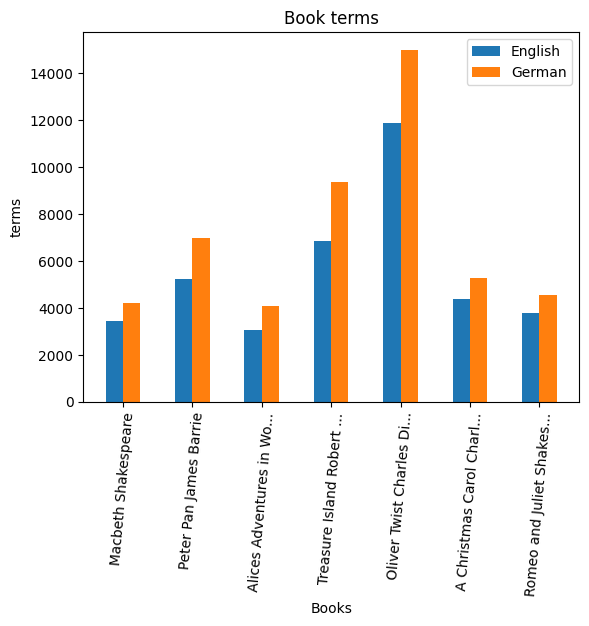

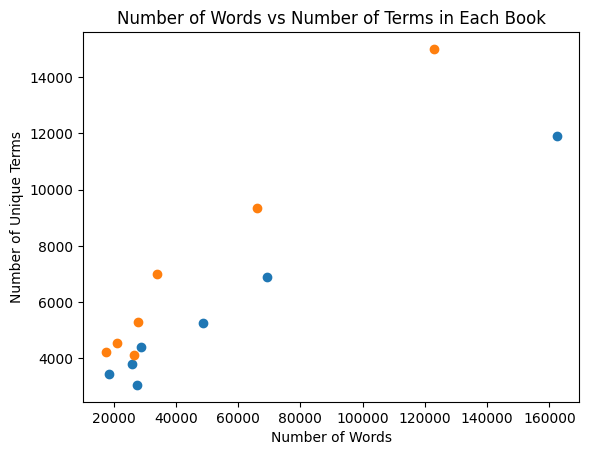

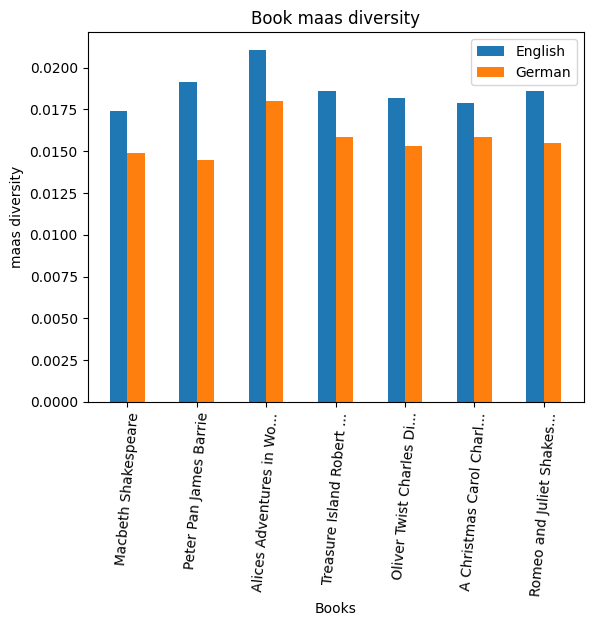

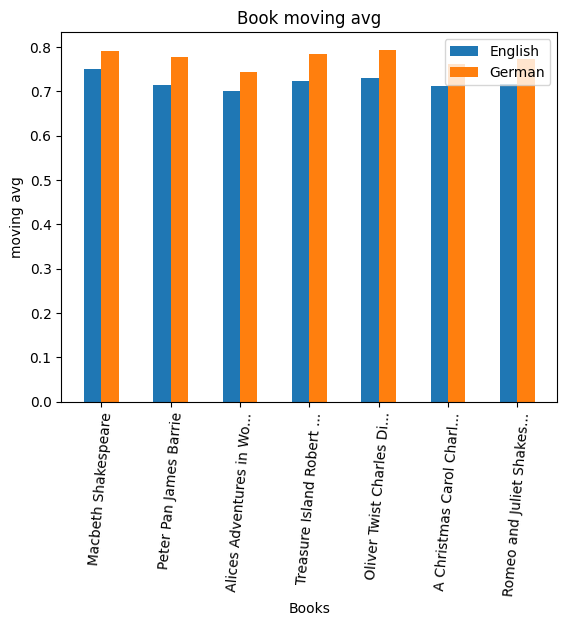

In [8]:
def plot_category(category, save_path=None, output_plot=True):
    avg_dict = {'English':[], 'German':[]}
    for title in set(df['title']):
        data = df[df['title'] == title]
        for lang in avg_dict.keys():
            if lang in data['language'].values:
                avg_dict[lang].append(data[data['language'] == lang][category].values[0])
            else:
                avg_dict[lang].append(0)

    fig, ax = plt.subplots()
    X_axis  = np.arange(len(set(df['title'])))
    width   = 0.25

    ax.bar(X_axis - width/2, avg_dict['English'], width, label='English')
    ax.bar(X_axis + width/2, avg_dict['German'],  width, label='German')
    plt.title(f'Book {category}')
    plt.ylabel(category)
    plt.xlabel('Books')
    plt.xticks(X_axis, set(df['title']), rotation=85)
    plt.legend()
    if save_path != None:
        plt.savefig(save_path, bbox_inches='tight')
    if output_plot:
        plt.show()
    
    return avg_dict

# doing the plotting 
words_dict = plot_category('words', save_path='figures/words.png')
terms_dict = plot_category('terms', save_path='figures/terms.png')

# plot the number of words agains the number of terms
for lang in words_dict.keys():
    plt.scatter(words_dict[lang], terms_dict[lang], label=f'{lang} Books')
plt.title('Number of Words vs Number of Terms in Each Book')
plt.xlabel('Number of Words')
plt.ylabel('Number of Unique Terms')
plt.savefig('figures/words vs terms scatter.png')
plt.show()

maas_dict = plot_category('maas diversity', save_path='figures/maas diversity.png')
avg_dict  = plot_category('moving avg', save_path='figures/moving avg.png')

### Getting a Couple other Stats
The mean Maas Diversity and mean sliding average of all the books was calculated for each language, and a percent difference from the English version was output. 

In [9]:
maas_avg_engl = np.mean(maas_dict['English'])
maas_avg_germ = np.mean(maas_dict['German'])
maas_diff = abs(maas_avg_engl - maas_avg_germ) / maas_avg_engl

avg_avg_engl = np.mean(avg_dict['English'])
avg_avg_germ = np.mean(avg_dict['German'])
avg_diff = abs(avg_avg_engl - avg_avg_germ) / avg_avg_engl

print(f'Percent difference between Maas diversity in languages: {round(maas_diff * 100, 2)}%')
print(f'Percent difference between Sliding Average in languages: {round(avg_diff * 100, 2)}%')

Percent difference between Maas diversity in languages: 15.96%
Percent difference between Sliding Average in languages: 7.43%
